In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sklm
import xgboost as xgb
import matplotlib
import pickle

C:\Users\hp\Anaconda3\lib\site-packages\distributed\utils.py:134: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [WinError 10065] A socket operation was attempted to an unreachable host
  % (host, default, e), RuntimeWarning)


In [2]:
train = pd.read_csv('Train_maskedv2.csv')
test = pd.read_csv('Test_maskedv2.csv')
submissions = pd.read_csv('samplesubmissionv2.csv')
vd = pd.read_csv('variable_descriptions_v2.csv')

In [27]:
print(train.shape)
print(test.shape)

(3174, 47)
(1102, 46)


In [4]:
Labels = np.array(train['target_pct_vunerable'])
print(Labels)

[1.73980135 1.99338128 0.03834043 ... 0.95882823 1.02493356 5.28312496]


In [69]:
train = train.drop(['lan_sq'], axis = 1)
test = test.drop(['lan_sq'], axis = 1)

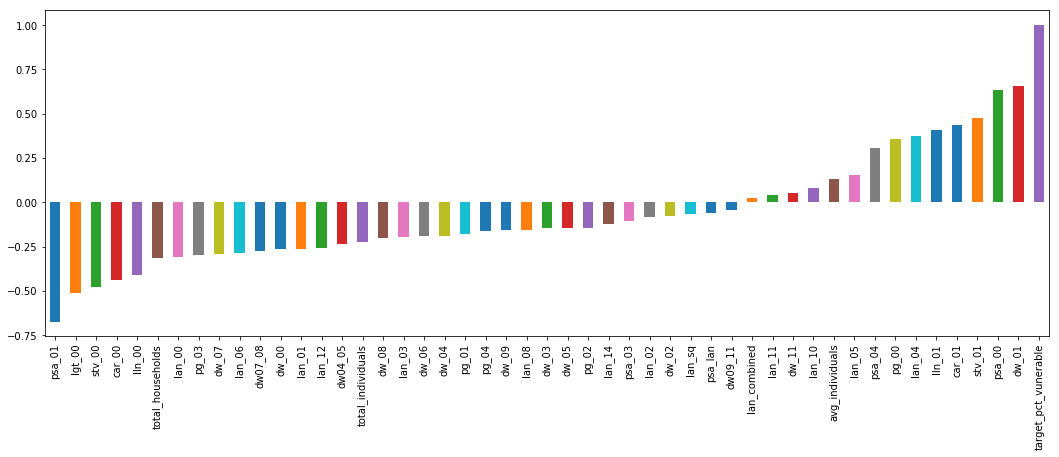

In [58]:
# Look at correlation with target
train.corr()['target_pct_vunerable'].sort_values().plot(kind='bar', figsize=(18, 6))

In [7]:
excluded_cols = ['dw_12', 'dw_13', 'lan_13', 'dw_10', 'psa_02', 'lan_07', 'lan_09']

for i in excluded_cols:
    test = test.drop(i, axis=1)
for j in excluded_cols:
    train = train.drop(j, axis=1)

In [8]:
train['avg_individuals'] = train['total_individuals'] / train['total_households']
test['avg_individuals'] = test['total_individuals'] / test['total_households']

In [55]:
train['lan_sq'] = train['lan_11'] * train['lan_10'] * train['lan_02'] * train['lan_14']
test['lan_sq'] = test['lan_11'] * test['lan_10'] * test['lan_02'] * test['lan_14']

In [79]:
train['target_pct_vunerable'] = Labels
train = train.drop(['target_pct_vunerable'], axis = 1)

In [44]:
train['inverse_dw02'] = train['psa_01'] ** train['lan_11']
test['inverse_dw02'] = test['psa_01'] ** test['lan_11']

In [82]:
test.shape

(1102, 47)

In [9]:
train1 = train.copy()

In [80]:
Features = np.array(train)
test_enc = np.array(test)

from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(Features[:, :2])
Features[:, :2] = scaler.transform(Features[:, :2])
print(Features[:, :2])

scaler1 = preprocessing.StandardScaler().fit(test_enc[:, :2])
test_enc[:, :2] = scaler1.transform(test_enc[:, :2])
print(test_enc[:, :2])

[[ 3.25349424  2.85925741]
 [ 3.2611637   2.1992301 ]
 [-0.23453747 -0.44538003]
 ...
 [ 0.93342628  1.8316802 ]
 [ 3.1076322   3.35482504]
 [ 0.25944328  0.27111737]]
[[-0.16503446 -0.35938299]
 [-0.42163757 -0.42024847]
 [-0.46203328 -0.6051864 ]
 ...
 [ 0.32568337  0.19777147]
 [-0.32950555 -0.10753076]
 [-0.38886785 -0.5674457 ]]


In [83]:
import numpy.random as nr
import sklearn.model_selection as ms
## Randomly sample cases to create independent training and test data
nr.seed(9988)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 0.2)
x_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
x_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

In [84]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=400, max_depth=10, max_features='auto',
                            min_samples_leaf=1, min_samples_split=2, random_state=0)
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [85]:
rf_pred = rf.predict(x_test)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mean_squared_error(rf_pred, y_test) ** 0.5

6.722881527910813

In [86]:

preds = rf.predict(test_enc)

In [87]:
#preds = xg_reg.predict(test_enc)
submissions.target_pct_vunerable = preds
submissions.to_csv('SouthAfricaCovid1.csv', index=False)

In [62]:
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 2000, seed = 123, max_depth = 10,
                           learning_rate=0.01, booster = 'dart', base_score = 0.7, subsample = 0.8,
                           reg_lambda = 0.03)

eval_set = [(x_test, y_test)]
xg_reg.fit(x_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True, early_stopping_rounds = 200)

[0]	validation_0-rmse:15.87971
Will train until validation_0-rmse hasn't improved in 200 rounds.
[1]	validation_0-rmse:15.75787
[2]	validation_0-rmse:15.63412
[3]	validation_0-rmse:15.50980
[4]	validation_0-rmse:15.39495
[5]	validation_0-rmse:15.27643
[6]	validation_0-rmse:15.15453
[7]	validation_0-rmse:15.03516
[8]	validation_0-rmse:14.91952
[9]	validation_0-rmse:14.80345
[10]	validation_0-rmse:14.68870
[11]	validation_0-rmse:14.57357
[12]	validation_0-rmse:14.46847
[13]	validation_0-rmse:14.35675
[14]	validation_0-rmse:14.25059
[15]	validation_0-rmse:14.14493
[16]	validation_0-rmse:14.04394
[17]	validation_0-rmse:13.93093
[18]	validation_0-rmse:13.82761
[19]	validation_0-rmse:13.72596
[20]	validation_0-rmse:13.62684
[21]	validation_0-rmse:13.53334
[22]	validation_0-rmse:13.42835
[23]	validation_0-rmse:13.33111
[24]	validation_0-rmse:13.24381
[25]	validation_0-rmse:13.14690
[26]	validation_0-rmse:13.05934
[27]	validation_0-rmse:12.96800
[28]	validation_0-rmse:12.88029
[29]	validation_

[256]	validation_0-rmse:6.82883
[257]	validation_0-rmse:6.82653
[258]	validation_0-rmse:6.82401
[259]	validation_0-rmse:6.82124
[260]	validation_0-rmse:6.81779
[261]	validation_0-rmse:6.81584
[262]	validation_0-rmse:6.81305
[263]	validation_0-rmse:6.80989
[264]	validation_0-rmse:6.80760
[265]	validation_0-rmse:6.80682
[266]	validation_0-rmse:6.80446
[267]	validation_0-rmse:6.80184
[268]	validation_0-rmse:6.79938
[269]	validation_0-rmse:6.79655
[270]	validation_0-rmse:6.79384
[271]	validation_0-rmse:6.79123
[272]	validation_0-rmse:6.78920
[273]	validation_0-rmse:6.78742
[274]	validation_0-rmse:6.78611
[275]	validation_0-rmse:6.78347
[276]	validation_0-rmse:6.78110
[277]	validation_0-rmse:6.77990
[278]	validation_0-rmse:6.77830
[279]	validation_0-rmse:6.77636
[280]	validation_0-rmse:6.77422
[281]	validation_0-rmse:6.77078
[282]	validation_0-rmse:6.76897
[283]	validation_0-rmse:6.76680
[284]	validation_0-rmse:6.76455
[285]	validation_0-rmse:6.76235
[286]	validation_0-rmse:6.76046
[287]	va

[513]	validation_0-rmse:6.64157
[514]	validation_0-rmse:6.64121
[515]	validation_0-rmse:6.64131
[516]	validation_0-rmse:6.64104
[517]	validation_0-rmse:6.64102
[518]	validation_0-rmse:6.64077
[519]	validation_0-rmse:6.64072
[520]	validation_0-rmse:6.64085
[521]	validation_0-rmse:6.64087
[522]	validation_0-rmse:6.64070
[523]	validation_0-rmse:6.64070
[524]	validation_0-rmse:6.64072
[525]	validation_0-rmse:6.64082
[526]	validation_0-rmse:6.64095
[527]	validation_0-rmse:6.64103
[528]	validation_0-rmse:6.64076
[529]	validation_0-rmse:6.64080
[530]	validation_0-rmse:6.64062
[531]	validation_0-rmse:6.64070
[532]	validation_0-rmse:6.64063
[533]	validation_0-rmse:6.64058
[534]	validation_0-rmse:6.64037
[535]	validation_0-rmse:6.64028
[536]	validation_0-rmse:6.64023
[537]	validation_0-rmse:6.63996
[538]	validation_0-rmse:6.63984
[539]	validation_0-rmse:6.63962
[540]	validation_0-rmse:6.63933
[541]	validation_0-rmse:6.63902
[542]	validation_0-rmse:6.63901
[543]	validation_0-rmse:6.63883
[544]	va

[770]	validation_0-rmse:6.62786
[771]	validation_0-rmse:6.62782
[772]	validation_0-rmse:6.62777
[773]	validation_0-rmse:6.62771
[774]	validation_0-rmse:6.62768
[775]	validation_0-rmse:6.62770
[776]	validation_0-rmse:6.62786
[777]	validation_0-rmse:6.62782
[778]	validation_0-rmse:6.62777
[779]	validation_0-rmse:6.62777
[780]	validation_0-rmse:6.62772
[781]	validation_0-rmse:6.62775
[782]	validation_0-rmse:6.62763
[783]	validation_0-rmse:6.62760
[784]	validation_0-rmse:6.62756
[785]	validation_0-rmse:6.62762
[786]	validation_0-rmse:6.62761
[787]	validation_0-rmse:6.62756
[788]	validation_0-rmse:6.62749
[789]	validation_0-rmse:6.62753
[790]	validation_0-rmse:6.62750
[791]	validation_0-rmse:6.62754
[792]	validation_0-rmse:6.62753
[793]	validation_0-rmse:6.62756
[794]	validation_0-rmse:6.62759
[795]	validation_0-rmse:6.62752
[796]	validation_0-rmse:6.62751
[797]	validation_0-rmse:6.62746
[798]	validation_0-rmse:6.62735
[799]	validation_0-rmse:6.62736
[800]	validation_0-rmse:6.62731
[801]	va

[1026]	validation_0-rmse:6.62497
[1027]	validation_0-rmse:6.62499
[1028]	validation_0-rmse:6.62499
[1029]	validation_0-rmse:6.62500
[1030]	validation_0-rmse:6.62499
[1031]	validation_0-rmse:6.62499
[1032]	validation_0-rmse:6.62499
[1033]	validation_0-rmse:6.62500
[1034]	validation_0-rmse:6.62501
[1035]	validation_0-rmse:6.62502
[1036]	validation_0-rmse:6.62500
[1037]	validation_0-rmse:6.62502
[1038]	validation_0-rmse:6.62502
[1039]	validation_0-rmse:6.62502
[1040]	validation_0-rmse:6.62503
[1041]	validation_0-rmse:6.62503
[1042]	validation_0-rmse:6.62503
[1043]	validation_0-rmse:6.62503
[1044]	validation_0-rmse:6.62501
[1045]	validation_0-rmse:6.62503
[1046]	validation_0-rmse:6.62504
[1047]	validation_0-rmse:6.62506
[1048]	validation_0-rmse:6.62507
[1049]	validation_0-rmse:6.62506
[1050]	validation_0-rmse:6.62508
[1051]	validation_0-rmse:6.62505
[1052]	validation_0-rmse:6.62502
[1053]	validation_0-rmse:6.62499
[1054]	validation_0-rmse:6.62497
[1055]	validation_0-rmse:6.62497
[1056]	val

[1275]	validation_0-rmse:6.62437
[1276]	validation_0-rmse:6.62437
[1277]	validation_0-rmse:6.62437
[1278]	validation_0-rmse:6.62437
[1279]	validation_0-rmse:6.62438
[1280]	validation_0-rmse:6.62437
[1281]	validation_0-rmse:6.62438
[1282]	validation_0-rmse:6.62438
[1283]	validation_0-rmse:6.62437
[1284]	validation_0-rmse:6.62437
[1285]	validation_0-rmse:6.62439
[1286]	validation_0-rmse:6.62438
[1287]	validation_0-rmse:6.62438
[1288]	validation_0-rmse:6.62439
[1289]	validation_0-rmse:6.62441
[1290]	validation_0-rmse:6.62442
[1291]	validation_0-rmse:6.62441
[1292]	validation_0-rmse:6.62441
[1293]	validation_0-rmse:6.62442
[1294]	validation_0-rmse:6.62443
[1295]	validation_0-rmse:6.62443
[1296]	validation_0-rmse:6.62441
[1297]	validation_0-rmse:6.62442
[1298]	validation_0-rmse:6.62443
[1299]	validation_0-rmse:6.62442
[1300]	validation_0-rmse:6.62443
[1301]	validation_0-rmse:6.62443
[1302]	validation_0-rmse:6.62443
[1303]	validation_0-rmse:6.62444
[1304]	validation_0-rmse:6.62444
[1305]	val

[1524]	validation_0-rmse:6.62437
[1525]	validation_0-rmse:6.62437
[1526]	validation_0-rmse:6.62437
[1527]	validation_0-rmse:6.62436
[1528]	validation_0-rmse:6.62436
[1529]	validation_0-rmse:6.62436
[1530]	validation_0-rmse:6.62435
[1531]	validation_0-rmse:6.62435
[1532]	validation_0-rmse:6.62434
[1533]	validation_0-rmse:6.62435
[1534]	validation_0-rmse:6.62435
[1535]	validation_0-rmse:6.62434
[1536]	validation_0-rmse:6.62434
[1537]	validation_0-rmse:6.62434
[1538]	validation_0-rmse:6.62434
[1539]	validation_0-rmse:6.62434
[1540]	validation_0-rmse:6.62436
[1541]	validation_0-rmse:6.62436
[1542]	validation_0-rmse:6.62436
[1543]	validation_0-rmse:6.62436
[1544]	validation_0-rmse:6.62436
[1545]	validation_0-rmse:6.62436
[1546]	validation_0-rmse:6.62436
[1547]	validation_0-rmse:6.62436
[1548]	validation_0-rmse:6.62435
[1549]	validation_0-rmse:6.62435
[1550]	validation_0-rmse:6.62435
[1551]	validation_0-rmse:6.62435
[1552]	validation_0-rmse:6.62435
[1553]	validation_0-rmse:6.62435
[1554]	val

[1773]	validation_0-rmse:6.62425
[1774]	validation_0-rmse:6.62425
[1775]	validation_0-rmse:6.62425
[1776]	validation_0-rmse:6.62425
[1777]	validation_0-rmse:6.62426
[1778]	validation_0-rmse:6.62425
[1779]	validation_0-rmse:6.62425
[1780]	validation_0-rmse:6.62425
[1781]	validation_0-rmse:6.62425
[1782]	validation_0-rmse:6.62425
[1783]	validation_0-rmse:6.62425
[1784]	validation_0-rmse:6.62425
[1785]	validation_0-rmse:6.62426
[1786]	validation_0-rmse:6.62425
[1787]	validation_0-rmse:6.62425
[1788]	validation_0-rmse:6.62425
[1789]	validation_0-rmse:6.62425
[1790]	validation_0-rmse:6.62426
[1791]	validation_0-rmse:6.62425
[1792]	validation_0-rmse:6.62425
[1793]	validation_0-rmse:6.62425
[1794]	validation_0-rmse:6.62425
[1795]	validation_0-rmse:6.62425
[1796]	validation_0-rmse:6.62426
[1797]	validation_0-rmse:6.62426
[1798]	validation_0-rmse:6.62426
[1799]	validation_0-rmse:6.62426
[1800]	validation_0-rmse:6.62426
[1801]	validation_0-rmse:6.62426
[1802]	validation_0-rmse:6.62426
[1803]	val

XGBRegressor(base_score=0.7, booster='dart', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.01, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=2000, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=123, reg_alpha=0,
       reg_lambda=0.03, scale_pos_weight=1, seed=123, subsample=0.8,
       tree_method=None, validate_parameters=False, verbosity=None)

In [63]:
preds = xg_reg.predict(test_enc)
submissions.target_pct_vunerable = preds
submissions.to_csv('SouthAfricaCovid1.csv', index=False)

In [39]:
train.describe()

,total_households,total_individuals,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,...,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,avg_individuals,lan_combined,dw_combined
count,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,...,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000
mean,3429.319013,12407.679534,0.710593,0.097372,0.031894,0.005820,0.008202,0.006047,0.022225,0.038319,...,0.014335,0.863095,0.041924,0.017665,0.073692,0.003624,0.830599,5.185855,0.117778,0.039649
std,3117.342795,9310.300318,0.217458,0.188484,0.078634,0.018592,0.029408,0.023772,0.036762,0.057300,...,0.041155,0.248096,0.146524,0.074607,0.169049,0.010378,0.208129,68.575808,0.218162,0.081812
min,1.000000,402.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.011053,0.000000,0.000000,0.000000,0.000000,0.001692,1.254742,0.000444,0.000000
25%,1668.367500,6972.024960,0.591480,0.002919,0.002421,0.000000,0.000000,0.000000,0.002676,0.004586,...,0.000000,0.879603,0.000960,0.000848,0.000445,0.000633,0.788085,3.305825,0.012594,0.005977
50%,2263.921720,9217.504670,0.766925,0.010649,0.005792,0.000803,0.000603,0.000813,0.008408,0.015730,...,0.000097,0.989811,0.003088,0.001753,0.001206,0.001630,0.909446,3.821129,0.029264,0.013817
75%,3681.155303,13463.543668,0.885571,0.074650,0.028085,0.002538,0.002145,0.002921,0.025111,0.046804,...,0.011548,0.995798,0.012419,0.004636,0.039255,0.004025,0.963780,4.400223,0.110109,0.040035
max,39595.195110,91716.746370,0.994962,0.931490,0.951806,0.264239,0.392085,0.435912,0.412936,0.455815,...,0.998448,1.000000,0.969519,0.939564,0.940563,0.367842,1.000000,3867.000000,0.998448,1.000000
